# Reduziertes Krebsrisikomodell für die Streamlit-Anwendung

## Zielsetzung

Neben dem umfassenden statistischen Modell wird ein reduziertes Risikomodell entwickelt, das speziell für eine interaktive Anwendung konzipiert ist.

Ziel ist eine transparente, niedrigschwellige und benutzerfreundliche Risikoeinschätzung auf Basis selbstberichteter, leicht zugänglicher Variablen.

Der Fokus liegt auf der Sensitivität (Recall), da im präventiven Kontext falsch-negative Vorhersagen als besonders kritisch gelten.


## Zweistufiges Risikokonzept

Das Risikomodell ist als zweistufiges Konzept angelegt:

**Stufe 1 – Basisrisiko (Selbstangaben):**
- Nutzung ausschließlich selbstberichteter Variablen
- Einsatz als Screening-Instrument
- Anpassbarer Entscheidungsschwellenwert

**Stufe 2 – Erweiterungsmodul (optional):**
- Integration klinischer Laborparameter
- Präzisere Risikoeinschätzung
- Separate Analyse im erweiterten Modell


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    classification_report
)

import matplotlib.pyplot as plt

## Datenbasis

Es werden die imputierten NHANES-Daten verwendet.

In [4]:
df = pd.read_csv("nhanes_clean.csv")

print("Observations:", df.shape[0])
print("Variables:", df.shape[1])

Observations: 7807
Variables: 52


## Bereinigung der Zielvariable

Ungültige Kategorien werden entfernt.
Anschließend erfolgt die binäre Kodierung:

- 1 = Krebs
- 0 = Kein Krebs

In [5]:
df = df[df["Lebenszeitprävalenz"].isin([1, 2])]
df["Lebenszeitprävalenz"] = df["Lebenszeitprävalenz"].map({1: 1, 2: 0})

df["Lebenszeitprävalenz"].value_counts(normalize=True)

Lebenszeitprävalenz
0    0.850128
1    0.149872
Name: proportion, dtype: float64

### Definition der Modellarchitektur  
**Level 1 – Screening-Modell**

Für das erste Modell (Basis-Screening) werden ausschließlich Variablen berücksichtigt, die:

- ohne Laboruntersuchung erhoben werden können  
- von den Nutzerinnen und Nutzern selbst angegeben werden können  
- klinisch plausibel mit Krebsrisiko assoziiert sind  
- im vollständigen Modell statistische Relevanz gezeigt haben  

Ziel ist ein kompaktes, praxisnahes Screening-Modell mit hoher Sensitivität, das als erste Risikoeinschätzung dient.  

Erweiterte klinische Messungen (z. B. Blutdruck) und Laborparameter werden in nachgelagerten Modellstufen berücksichtigt.

In [33]:
level_1_vars  = [

    # Demographics
    "Alter",
    "Geschlecht",
    "Höchster Bildungsabschluss",
    "Familienstand",
    "Verhältnis zwischen Familieneinkommen und Armut",

    # Health behavior
    "mind. 100 Zigaretten geraucht",
    "mind. einmal Alkohol getrunken",
    "wie oft wird Alkohol getrunken?",
    "Gibt es Zeiträume in denen sie täglich getrunken haben?",

    # Physical activity
    "Häufigkeit moderate körperliche Aktivitäten in Freizeit",
    "Sitzzeit pro Tag",

    # Sleep
    "Trouble sleeping or sleeping too much",

    # Pre-existing conditions
    "Asthma",
    "COPD",
    "Athritis",
    "Herzinfarkt",
    "Schlaganfall",
    "Schilddrüsenprobleme",

    # Anthropometry
    "BMI",

    # Mental health
    "Depressive Symptome"
]


In [34]:
# --- Clinical extension ---
level_2_clinical_vars = [
    "Hüftumfang (cm)",
    "Gewicht (kg)",
    "pulse",
    "sys_bp",
    "dia_bp",
    "Dauer der moderaten Aktivitäten",
    "Häufigkeit körperl. anstrengender Aktivitäten",
    "Schalfstunden unter der Woche",
    "Schalfstunden am Wochenende"
]

# --- Nutrition extension ---
level_2_nutrition_vars = [
    "Energy (kcal)",
    "Total sugars (gm)",
    "Total fat (gm)",
    "Dietary fiber (gm)",
    "Protein (gm)",
    "Cholesterol (mg)"
]

# --- Final Level 2 ---
level_2_vars = level_1_vars + level_2_clinical_vars + level_2_nutrition_vars

In [35]:
target = "Lebenszeitprävalenz"

X = df[level_1_vars]
y = df[target]

print("Number of selected variables:", len(X.columns))

Number of selected variables: 20


In [36]:
print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True))

X shape: (7800, 20)
y distribution:
Lebenszeitprävalenz
0    0.850128
1    0.149872
Name: proportion, dtype: float64


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))

Train distribution:
Lebenszeitprävalenz
0    0.85016
1    0.14984
Name: proportion, dtype: float64

Test distribution:
Lebenszeitprävalenz
0    0.85
1    0.15
Name: proportion, dtype: float64


### Modelltraining – Level 1

In [38]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=5000,
        class_weight="balanced"
    ))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=5000))])

In [39]:
y_pred_lvl1 = pipeline.predict(X_test)
y_probs_lvl1 = pipeline.predict_proba(X_test)[:, 1]

print("Recall:", recall_score(y_test, y_pred_lvl1))
print("Precision:", precision_score(y_test, y_pred_lvl1))
print("F1:", f1_score(y_test, y_pred_lvl1))
print("ROC-AUC:", roc_auc_score(y_test, y_probs_lvl1))

Recall: 0.7991452991452992
Precision: 0.2921875
F1: 0.4279176201372998
ROC-AUC: 0.7970987869177915


In [40]:
metrics_lvl1 = {
    "Model": "Level 1 - Self-Reported",
    "Recall": recall_score(y_test, y_pred_lvl1),
    "Precision": precision_score(y_test, y_pred_lvl1),
    "F1": f1_score(y_test, y_pred_lvl1),
    "ROC_AUC": roc_auc_score(y_test, y_probs_lvl1)
}

In [41]:
thresholds = [0.5, 0.45, 0.4, 0.35]

for t in thresholds:
    y_pred_t = (y_probs_lvl1 >= t).astype(int)
    print(f"Threshold {t}")
    print("Recall:", recall_score(y_test, y_pred_t))
    print("Precision:", precision_score(y_test, y_pred_t))
    print("-----")


Threshold 0.5
Recall: 0.7991452991452992
Precision: 0.2921875
-----
Threshold 0.45
Recall: 0.8504273504273504
Precision: 0.2814710042432815
-----
Threshold 0.4
Recall: 0.8931623931623932
Precision: 0.2672634271099744
-----
Threshold 0.35
Recall: 0.9273504273504274
Precision: 0.2532088681446908
-----


Der Schwellenwert von 0.40 wurde gewählt, um eine hohe Sensitivität (~90%) zu erreichen, während die Präzision noch auf einem vertretbaren Niveau bleibt. Im Kontext eines präventiven Screenings ist die Minimierung falsch-negativer Fälle prioritär.

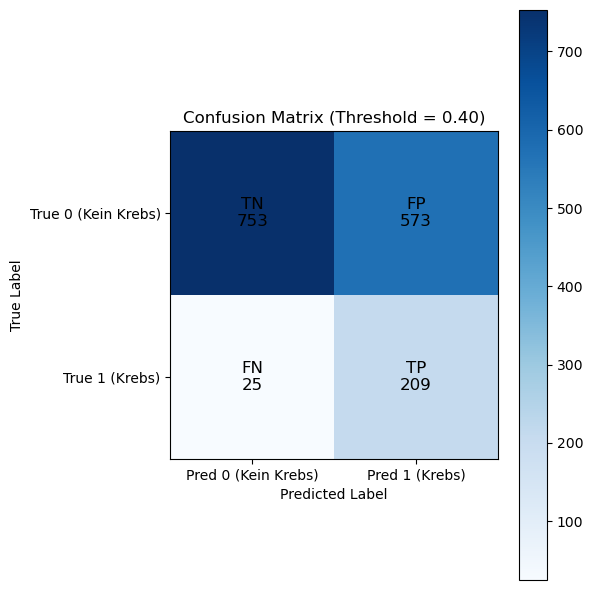

In [42]:
# Adjust decision threshold
threshold = 0.40
y_pred_adj = (y_probs_lvl1 >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_adj)

tn, fp, fn, tp = cm.ravel()

# Plot confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues")

plt.title("Confusion Matrix (Threshold = 0.40)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0,1], ["Pred 0 (Kein Krebs)", "Pred 1 (Krebs)"])
plt.yticks([0,1], ["True 0 (Kein Krebs)", "True 1 (Krebs)"])

# Annotate cells
plt.text(0, 0, f"TN\n{tn}", ha="center", va="center", fontsize=12)
plt.text(0, 1, f"FN\n{fn}", ha="center", va="center", fontsize=12)
plt.text(1, 0, f"FP\n{fp}", ha="center", va="center", fontsize=12)
plt.text(1, 1, f"TP\n{tp}", ha="center", va="center", fontsize=12)

plt.colorbar()
plt.tight_layout()
plt.show()

Die Konfusionsmatrix bei einem Entscheidungs­schwellenwert von 0.40 zeigt eine deutliche Verschiebung zugunsten der Sensitivität.

Mit einem Recall von ca. 0.90 werden rund 90 % der tatsächlichen Krebsfälle korrekt identifiziert (TP = 209), während lediglich 25 Fälle als falsch-negativ klassifiziert werden.
Im präventiven Kontext ist dies besonders relevant, da übersehene Risikopersonen (False Negatives) schwerwiegender sind als falsch-positive Einschätzungen.

Gleichzeitig steigt die Anzahl falsch-positiver Vorhersagen (FP = 573), was zu einer vergleichsweise niedrigen Präzision (≈ 0.27) führt. Das Modell neigt somit dazu, potenzielle Risiken eher großzügig zu markieren.

Diese Charakteristik entspricht einem typischen Screening-Ansatz:
Eine erhöhte Sensitivität wird bewusst in Kauf genommen, selbst wenn dies mit einer größeren Anzahl an Fehlalarmen verbunden ist.

Insgesamt stellt der Schwellenwert von 0.40 einen sachlich begründeten Kompromiss dar, wenn das Ziel in einer vorsorglichen Risikoabschätzung liegt und die Minimierung falsch-negativer Fälle priorisiert wird.

### Ergänzende Evaluierung

Zur vollständigen Beurteilung des Modells wird zusätzlich ein Klassifikationsbericht ausgegeben, der Präzision, Sensitivität und F1-Score für beide Klassen zusammenfasst.

In [ ]:

print("Final Evaluation - Level 1 (Threshold = 0.40)")
print(classification_report(y_test, y_pred_adj))

Final Evaluation - Level 1 (Threshold = 0.40)
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1326
           1       0.27      0.88      0.41       234

    accuracy                           0.62      1560
   macro avg       0.62      0.73      0.57      1560
weighted avg       0.86      0.62      0.67      1560



## Interpretation der Modellkoeffizienten

Da es sich um eine logistische Regression handelt, modelliert das Verfahren die Log-Odds der Lebenszeitprävalenz von Krebs.

Formal gilt:

$$
\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 X_1 + \dots + \beta_k X_k
$$

Die geschätzten Koeffizienten $\beta_i$ geben die Veränderung der Log-Odds pro Einheit der jeweiligen Variable an.

Zur besseren Interpretierbarkeit werden die Koeffizienten exponentiiert:

$$
\text{Odds Ratio} = e^{\beta_i}
$$

### Interpretation

- **Odds Ratio > 1** → erhöhtes Risiko  
- **Odds Ratio < 1** → protektiver Effekt  
- **Odds Ratio = 1** → kein Zusammenhang  

Da die Variablen standardisiert wurden, sind die Koeffizienten direkt vergleichbar.


In [43]:
# Extract coefficients from logistic regression model
coefs = pipeline.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Coefficient": coefs
})

# Calculate Odds Ratios
coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficient"])

# Sort by absolute effect size
coef_df = coef_df.sort_values(by="Odds_Ratio", ascending=False)

coef_df


,Variable,Coefficient,Odds_Ratio
0,Alter,1.253757,3.503481
2,Höchster Bildungsabschluss,0.169151,1.184299
1,Geschlecht,0.074400,1.077238
11,Trouble sleeping or sleeping too much,0.072956,1.075683
4,Verhältnis zwischen Familieneinkommen und Armut,0.049155,1.050383
3,Familienstand,0.039971,1.040780
8,Gibt es Zeiträume in denen sie täglich getrunk...,0.037587,1.038302
16,Schlaganfall,0.012272,1.012347
18,BMI,-0.013535,0.986556
9,Häufigkeit moderate körperliche Aktivitäten in...,-0.028497,0.971905


### Interpretation der wichtigsten Einflussfaktoren

Die Variablen mit den höchsten Odds Ratios weisen auf einen stärkeren positiven Zusammenhang mit der Krebsprävalenz hin. Variablen mit Odds Ratios unter 1 deuten auf einen möglichen protektiven Effekt oder eine inverse Assoziation hin.

Besonders relevant im Kontext eines selbstberichteten Screenings sind:

- demografische Faktoren (z. B. Alter)
- Lebensstilfaktoren (z. B. Rauchverhalten, Alkoholkonsum)
- Vorerkrankungen

Diese Ergebnisse unterstützen die klinische Plausibilität des reduzierten Modells.

### Zentrale Einflussfaktoren

Das Alter zeigt den stärksten positiven Zusammenhang mit der Krebs-Lebenszeitprävalenz. 

Auch sozioökonomische Faktoren wie der höchste Bildungsabschluss weisen einen relevanten Effekt auf.

Verhaltensbezogene Variablen (Alkoholkonsum, Raucherhistorie, körperliche Aktivität) tragen ebenfalls zur Risikodifferenzierung bei.

Mehrere Variablen mit Odds Ratios < 1 deuten auf potenziell protektive Zusammenhänge hin, wobei aufgrund des Querschnittdesigns keine kausalen Aussagen getroffen werden können.


### Modelltraining – Level 2

In [44]:
# Feature matrix for Level 2
X_lvl2 = df[level_2_vars]

X_train_lvl2, X_test_lvl2 = (
    X_lvl2.loc[X_train.index],
    X_lvl2.loc[X_test.index]
)

pipeline_lvl2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])

pipeline_lvl2.fit(X_train_lvl2, y_train)

y_probs_lvl2 = pipeline_lvl2.predict_proba(X_test_lvl2)[:, 1]
y_pred_lvl2 = (y_probs_lvl2 >= 0.40).astype(int)

In [45]:
metrics_lvl2 = {
    "Model": "Level 2 - Clinical + Nutrition",
    "Recall": recall_score(y_test, y_pred_lvl2),
    "Precision": precision_score(y_test, y_pred_lvl2),
    "F1": f1_score(y_test, y_pred_lvl2),
    "ROC_AUC": roc_auc_score(y_test, y_probs_lvl2)
}

In [32]:
comparison_df = pd.DataFrame([metrics_lvl1, metrics_lvl2])
comparison_df

,Model,Recall,Precision,F1,ROC_AUC
0,Level 1 - Self-Reported,0.799145,0.293103,0.428899,0.797170
1,Level 2 - Clinical + Nutrition,0.884615,0.270942,0.414830,0.792255


### Methodisches Vorgehen

Das Modell wurde als binäre logistische Regression implementiert.
Zur Berücksichtigung der Klassenimbalance wurde class_weight="balanced" verwendet.

Die Daten wurden mittels eines stratifizierten 80/20-Splits in Trainings- und Testdaten unterteilt, um eine vergleichbare Klassenverteilung sicherzustellen.

Die Modellleistung wurde anhand folgender Kennzahlen bewertet:

- Recall (Sensitivität)
- Precision
- F1-Score
- ROC-AUC

Da es sich um ein präventives Screening-Szenario handelt, wurde die Sensitivität priorisiert.
Der Entscheidungs­schwellenwert wurde auf 0.40 gesetzt, um falsch-negative Fälle zu minimieren.

### Modellvergleich: Basis vs. Erweiterte Version

Durch die Erweiterung um klinische Basisparameter (Blutdruck, anthropometrische Maße) sowie ausgewählte Ernährungsvariablen zeigt sich eine moderate Veränderung der Modellleistung.

Während Level 2 die Sensitivität erhöht (Recall ≈ 0.88 im Vergleich zu ≈ 0.80 in Level 1), bleibt die ROC-AUC nahezu unverändert. Dies deutet darauf hin, dass die zusätzliche Information zwar die Identifikation potenzieller Risikofälle verbessert, jedoch die globale Diskriminationsfähigkeit nur geringfügig beeinflusst.

Die Ergebnisse legen nahe, dass die selbstberichteten Variablen bereits einen Großteil der erklärbaren Varianz erfassen. Die Erweiterung um klinische und ernährungsbezogene Parameter führt zu einer leichten Verschiebung zugunsten der Sensitivität, ohne die Gesamtgüte des Modells substanziell zu steigern.

Somit stellt Level 1 eine robuste und niedrigschwellige Screening-Lösung dar, während Level 2 als optionale Erweiterung für eine differenziertere Risikoeinschätzung dienen kann.

## Methodische Einordnung

Das reduzierte Modell ist als niedrigschwelliger Screening-Ansatz konzipiert. 

Es basiert ausschließlich auf selbstberichteten und leicht zugänglichen Variablen und eignet sich daher für eine Integration in eine interaktive Anwendung (z. B. Streamlit).

Die Modellleistung ist im Vergleich zum vollständigen Modell leicht reduziert, bleibt jedoch hinsichtlich Sensitivität stabil.

In einem zweiten Schritt kann das Modell optional um klinische Laborparameter erweitert werden, um die Risikoprognose weiter zu verfeinern.


# Fazit

Die Ergebnisse zeigen, dass bereits selbstberichtete Variablen eine stabile prädiktive Leistungsfähigkeit ermöglichen.

Die Erweiterung um klinische Basisparameter und Ernährungsvariablen führt zu einer leichten Verbesserung der Sensitivität, ohne jedoch die globale Diskriminationsfähigkeit signifikant zu steigern.

Für ein niedrigschwelliges präventives Screening erscheint das reduzierte Modell als methodisch robuste und praktikable Lösung.

Die erweiterte Version kann optional eingesetzt werden, wenn zusätzliche klinische Informationen verfügbar sind.

In [46]:
# Save final model for Streamlit deployment
import joblib

joblib.dump(pipeline_lvl2, "risk_model_lvl2.pkl")

['risk_model_lvl2.pkl']